In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_test_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_test_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
predict_data = pd.read_csv("/kaggle/input/titanic/test.csv")
predict_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
women = train_test_data.loc[train_test_data.Sex == "female"]["Survived"]
rate_women = sum(women)/len(women)

print(rate_women)

0.7420382165605095


In [5]:
men = train_test_data.loc[train_test_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print(rate_men)

0.18890814558058924


In [6]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset 
import matplotlib.pyplot as plt

In [7]:
#超参数设置
batch_size=32
lr=0.2
num_inputs=6
num_hiddens_max=10
num_outputs=2
w_std=0.01
num_epochs=10
num_test=128

In [8]:
#设计神经网络，初始化模型参数
def net_1h(num_hiddens):
    net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(num_inputs,num_hiddens),
        nn.ReLU(),
        nn.Linear(num_hiddens,num_outputs)
    )
    
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight,std=w_std)
    
    net.apply(init_weights)
    # net[1].weight.data.normal_(0, 0.01)
    # net[1].bias.data.fill_(0)
    # net[3].weight.data.normal_(0, 0.01)
    # net[3].bias.data.fill_(0)

    #设置交叉熵损失函数
    loss = nn.CrossEntropyLoss(reduction='none')
    
    #设置优化器
    trainer = torch.optim.SGD(net.parameters(),lr)

    return net,loss,trainer

In [9]:
#提取训练集、测试集和验证集
features = ["Pclass","Sex","Age","SibSp","Parch","Fare"]
for f in [train_test_data,predict_data]:
    f['Sex'] = f['Sex'].map({'female': 0, 'male': 1}).astype('int64')
    for feature in features:
        f[feature] = f[feature].fillna(train_test_data[feature].mean()) # 用train_data[feature]的平均值
F_train = (train_test_data[features].values)[:train_test_data.shape[0] - num_test,:] # 后缀values转化为numpy数组
L_train = (train_test_data["Survived"].values)[:train_test_data.shape[0] - num_test]
F_test = (train_test_data[features].values)[train_test_data.shape[0] - num_test:,:]
L_test = (train_test_data["Survived"].values)[train_test_data.shape[0] - num_test:]
F_predict = predict_data[features].values

In [10]:
#数据预处理：归一化处理
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_F_train = scaler.fit_transform(F_train)
scaled_F_test = scaler.transform(F_test)
scaled_F_predict = scaler.transform(F_predict)

In [11]:
#将数据转化为tensor张量
F_train_tensor = torch.tensor(scaled_F_train,dtype=torch.float32)
L_train_tensor = torch.tensor(L_train,dtype=torch.float32)
F_test_tensor = torch.tensor(scaled_F_test,dtype=torch.float32)
L_test_tensor = torch.tensor(L_test,dtype=torch.float32)
F_predict_tensor = torch.tensor(scaled_F_predict,dtype=torch.float32)

In [12]:
#将数据转化为DataLoader
train_set = TensorDataset(F_train_tensor,L_train_tensor)
test_set = TensorDataset(F_test_tensor,L_test_tensor)
train_iter = DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_iter = DataLoader(test_set,batch_size=batch_size,shuffle=False)

In [13]:
#准确量函数
def accuracy(y_hat,y):
    y_hat = np.argmax(y_hat.detach(),axis=1)
    cmp = y_hat.type(y.dtype)==y
    return float(cmp.type(y.dtype).sum())

In [14]:
#准确率函数
def evaluate_accuracy(net,data_iter):
    if isinstance(net,torch.nn.Module):
        net.eval()
    with torch.no_grad():
        for X,y in data_iter:
        #     metric.add(accuracy(net(X),y),y.numel())
            return accuracy(net(X),y)/y.numel()

In [15]:
#单轮训练函数
def train_epoch(net,train_iter,loss,updater):
    if isinstance(net,torch.nn.Module):
        net.train()
    
    for X,y in train_iter:
        updater.zero_grad()
        y_hat = net(X)
        l = loss(y_hat,y.long())
        l.mean().backward()
        updater.step()

    return float(l.sum())/y.numel(),accuracy(y_hat,y)/y.numel()

In [16]:
#总训练函数
def train(net,train_iter,test_iter,loss,num_epochs,updater):
    train_losses,train_accs,test_accs = [],[],[]
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net,train_iter,loss,updater)
        test_acc = evaluate_accuracy(net,test_iter)
        train_losses.append(train_metrics[0])
        train_accs.append(train_metrics[1])
        test_accs.append(test_acc)
    return train_losses,train_accs,test_accs

In [17]:
#训练模型
train_losses,train_accs,test_accs = [],[],[]
t_data = [train_losses,train_accs,test_accs]
for num_hiddens in range(1,num_hiddens_max+1):
    n = net_1h(num_hiddens)
    data = train(n[0],train_iter,test_iter,n[1],num_epochs,n[2])
    t_data[0].append(data[0])
    t_data[1].append(data[1])
    t_data[2].append(data[2])

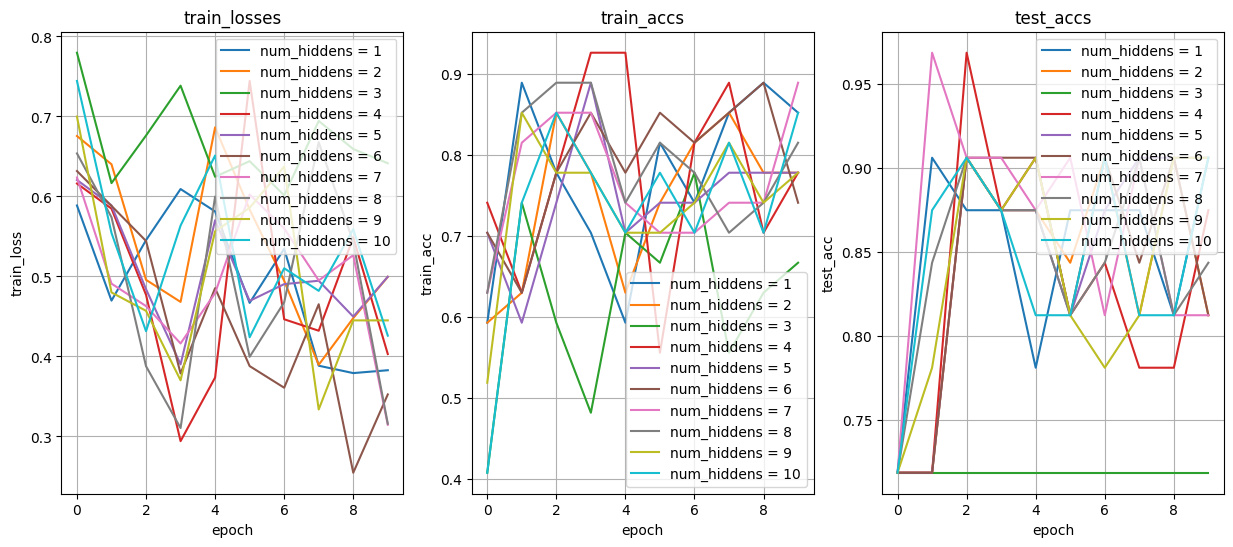

In [18]:
%matplotlib inline
x=range(num_epochs)
fig,ax = plt.subplots(1,3,figsize=(15,6))
title = ["train_losses","train_accs","test_accs"]
y_label = ["train_loss","train_acc","test_acc"]
label = [f"num_hiddens = {i}" for i in range(1,num_hiddens_max+1)]
for n in range(3):
    for i in range(1,num_hiddens_max+1):
        ax[n].plot(x,t_data[n][i-1],label = label[i-1])
    ax[n].set_title(title[n])
    ax[n].grid(True)
    ax[n].set_xlabel('epoch')
    ax[n].set_ylabel(y_label[n])
    ax[n].legend()

plt.show()

In [19]:
m=net_1h(num_hiddens_max)
data = train(m[0],train_iter,test_iter,m[1],num_epochs,m[2])
preds = m[0](F_predict_tensor).argmax(1)

In [20]:
output = pd.DataFrame({'PassengerId': predict_data.PassengerId, 'Survived': preds})
output.to_csv('submission.csv', index=False)